<a href="https://colab.research.google.com/github/hyacob-89/fake_news_detector/blob/master/fake_news_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <u>__Dependencies__<u/>

In [0]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()


In [0]:
# Basic libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [0]:
 !wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2020-05-15 01:27:37--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  4.74MB/s    in 0.2s    

2020-05-15 01:27:37 (4.74 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



## <u>__Extract__<u/>

In [0]:
from pyspark import SparkFiles
# Load in fake.csv file from S3 into a DataFrame
fake_news_url = "https://news-detector-project.s3.us-east-2.amazonaws.com/FakeNews.csv"
spark.sparkContext.addFile(fake_news_url)

fake = spark.read.option('header', 'true').csv(SparkFiles.get("FakeNews.csv"), inferSchema=True, sep=',', timestampFormat="mm/dd/yy")
fake.show()

+--------------------+--------------------+--------------+-----------+
|               title|         articletext|articlesubject|articledate|
+--------------------+--------------------+--------------+-----------+
| Donald Trump Sen...|Donald Trump just...|          News|  31-Dec-17|
| Drunk Bragging T...|House Intelligenc...|          News|  31-Dec-17|
| Sheriff David Cl...|On Friday, it was...|          News|  30-Dec-17|
| Trump Is So Obse...|On Christmas day,...|          News|  29-Dec-17|
| Pope Francis Jus...|Pope Francis used...|          News|  25-Dec-17|
| Racist Alabama C...|The number of cas...|          News|  25-Dec-17|
| Fresh Off The Go...|Donald Trump spen...|          News|  23-Dec-17|
| Trump Said Some ...|In the wake of ye...|          News|  23-Dec-17|
| Former CIA Direc...|Many people have ...|          News|  22-Dec-17|
| WATCH: Brand-New...|Just when you mig...|          News|  21-Dec-17|
| Papa John’s Foun...|A centerpiece of ...|          News|  21-Dec-17|
| WATC

In [0]:
from pyspark import SparkFiles
# Load in CSV files from S3 into a DataFrame
true_news_url = "https://news-detector-project.s3.us-east-2.amazonaws.com/TrueNews.csv"
spark.sparkContext.addFile(true_news_url)

true = spark.read.option('header', 'true').csv(SparkFiles.get("TrueNews.csv"), inferSchema=True, sep=',', timestampFormat="mm/dd/yy")

In [0]:
true.show(20)

+--------------------+--------------------+--------------------+------------+
|               title|         articletext|      articlesubject| articledate|
+--------------------+--------------------+--------------------+------------+
|As U.S. budget fi...|WASHINGTON (Reute...|        politicsNews|   31-Dec-17|
|U.S. military to ...|WASHINGTON (Reute...|        politicsNews|   29-Dec-17|
|Senior U.S. Repub...|WASHINGTON (Reute...|        politicsNews|   31-Dec-17|
|FBI Russia probe ...|WASHINGTON (Reute...|        politicsNews|   30-Dec-17|
|Trump wants Posta...|SEATTLE/WASHINGTO...|        politicsNews|   29-Dec-17|
|White House, Cong...|WEST PALM BEACH, ...|        politicsNews|   29-Dec-17|
|Trump says Russia...|WEST PALM BEACH, ...|        politicsNews|   29-Dec-17|
|Factbox: Trump on...|The following sta...|        politicsNews|   29-Dec-17|
|Trump on Twitter ...|The following sta...|        politicsNews|   29-Dec-17|
|Alabama official ...|WASHINGTON (Reute...|        politicsNews|

## <u>__Transform__<u/>

In [0]:
import pandas as pd
fake_df = fake.toPandas() 
fake_df.head()

,title,articletext,articlesubject,articledate
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,31-Dec-17
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31-Dec-17
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,30-Dec-17
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,29-Dec-17
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,25-Dec-17


In [0]:
true_df = true.toPandas() 
true_df.head(20)

,title,articletext,articlesubject,articledate
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,29-Dec-17
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,29-Dec-17
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,29-Dec-17
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,29-Dec-17
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,28-Dec-17


In [0]:
# Deleting a specific row  not coresponding with the consequancy of rows
true_df.drop(true_df.index[[13]], inplace=True)
true_df.head(20)

,title,articletext,articlesubject,articledate
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,29-Dec-17
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,29-Dec-17
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,29-Dec-17
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,29-Dec-17
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,28-Dec-17


In [0]:
fake_df['label'] = 1
fake_df.head()

,title,articletext,articlesubject,articledate,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,31-Dec-17,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31-Dec-17,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,30-Dec-17,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,29-Dec-17,1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,25-Dec-17,1


In [0]:
true_df['label'] = 0
true_df.head()

,title,articletext,articlesubject,articledate,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17,0


In [0]:
def clean_data_text(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='articletext', inplace=True)
    
    # Remove punctation
    dataframe['articletext'] = dataframe['articletext'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['articletext'] = dataframe['articletext'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['articletext'] = dataframe['articletext'].str.replace('  ',' ')
    dataframe['articletext'] = dataframe['articletext'].str.replace('  ',' ')

    # Transform all text to lowercase
    dataframe['articletext'] = dataframe['articletext'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

In [0]:
# Call `clean_data_text(dataframe)` function
clean_data_text(fake_df)

New shape: (17437, 5)


,title,articletext,articlesubject,articledate,label
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump just couldn t wish all americans ...,News,31-Dec-17,1
1,Drunk Bragging Trump Staffer Started Russian ...,house intelligence committee chairman devin nu...,News,31-Dec-17,1
2,Sheriff David Clarke Becomes An Internet Joke...,on friday it was revealed that former milwauke...,News,30-Dec-17,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,on christmas day donald trump announced that h...,News,29-Dec-17,1
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis used his annual christmas day mes...,News,25-Dec-17,1


In [0]:
# Call `clean_data_text(dataframe)` function
clean_data_text(true_df)

New shape: (21191, 5)


,title,articletext,articlesubject,articledate,label
0,"As U.S. budget fight looms, Republicans flip t...",washington reuters the head of a conservative ...,politicsNews,31-Dec-17,0
1,U.S. military to accept transgender recruits o...,washington reuters transgender people will be ...,politicsNews,29-Dec-17,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuters the special counsel investi...,politicsNews,31-Dec-17,0
3,FBI Russia probe helped by Australian diplomat...,washington reuters trump campaign adviser geor...,politicsNews,30-Dec-17,0
4,Trump wants Postal Service to charge 'much mor...,seattle washington reuters president donald tr...,politicsNews,29-Dec-17,0


In [0]:
# droping nan values for fake df
fake_df = fake_df[fake_df.articletext.isna() == False]
l =len(fake_df)
print('rows after removing nans: ', l)
rando = list(np.random.choice(l-2, 4001, replace=True))
fake_df =fake_df.iloc[rando]


rows after removing nans:  17436


In [0]:
# droping nan values for true df
true_df = true_df[true_df.articletext.isna() == False]
l =len(true_df)
print('rows after removing nans: ', l)
rando = list(np.random.choice(l-2, 4001, replace=True))
true_df =true_df.iloc[rando]

rows after removing nans:  21191


In [0]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4001 entries, 13675 to 84
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           4001 non-null   object
 1   articletext     4001 non-null   object
 2   articlesubject  4001 non-null   object
 3   articledate     4001 non-null   object
 4   label           4001 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 187.5+ KB


In [0]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4001 entries, 12045 to 9221
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           4001 non-null   object
 1   articletext     4001 non-null   object
 2   articlesubject  4001 non-null   object
 3   articledate     4001 non-null   object
 4   label           4001 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 187.5+ KB


**Tokenization**
(these couple rows of df2 will not be saved in cvs file)

In [0]:
df2 = pd.concat([fake_df[['articletext','articlesubject', 'label']], true_df[['articletext','articlesubject', 'label']]], axis=0)

#Reset the index
# df1 = df1.set_index(inplace=True)

# r
print("Shape:", df2.shape)
df2.head()

Shape: (8002, 3)


,articletext,articlesubject,label
13675,the obama administration s cleansing of the is...,politics,1
12427,here s how mcnaughton describes the painting a...,politics,1
18248,legal latino heat filmed a tent city full of ...,left-news,1
8661,there are many many things i would call senato...,News,1
9154,on wednesday a jubilant president trump tweete...,politics,1


In [0]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
#Function to remove Punctuation
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])# It will discard all punctuations
    return text_nopunct

df2['body_text_clean'] = df2['articletext'].apply(lambda x: remove_punct(x))

df2.head()

,articletext,articlesubject,label,body_text_clean
13675,the obama administration s cleansing of the is...,politics,1,the obama administration s cleansing of the is...
12427,here s how mcnaughton describes the painting a...,politics,1,here s how mcnaughton describes the painting a...
18248,legal latino heat filmed a tent city full of ...,left-news,1,legal latino heat filmed a tent city full of ...
8661,there are many many things i would call senato...,News,1,there are many many things i would call senato...
9154,on wednesday a jubilant president trump tweete...,politics,1,on wednesday a jubilant president trump tweete...


In [0]:
import re
# Function to Tokenize words
def tokenize(text):
    tokens = re.split('\W+', text) #W+ means that either a word character (A-Za-z0-9_) or a dash (-) can go there.
    return tokens

df2['body_text_tokenized'] = df2['body_text_clean'].apply(lambda x: tokenize(x.lower())) 
#We convert to lower as Python is case-sensitive. 

df2.head()

,articletext,articlesubject,label,body_text_clean,body_text_tokenized
13675,the obama administration s cleansing of the is...,politics,1,the obama administration s cleansing of the is...,"[the, obama, administration, s, cleansing, of,..."
12427,here s how mcnaughton describes the painting a...,politics,1,here s how mcnaughton describes the painting a...,"[here, s, how, mcnaughton, describes, the, pai..."
18248,legal latino heat filmed a tent city full of ...,left-news,1,legal latino heat filmed a tent city full of ...,"[, legal, latino, heat, filmed, a, tent, city,..."
8661,there are many many things i would call senato...,News,1,there are many many things i would call senato...,"[there, are, many, many, things, i, would, cal..."
9154,on wednesday a jubilant president trump tweete...,politics,1,on wednesday a jubilant president trump tweete...,"[on, wednesday, a, jubilant, president, trump,..."


In [0]:
# Saving it for the future use
# fake_df.to_csv("Users/bolboceanunicolai/Desktop/Final Project/data_test/FakeNews_Clean.csv")
# true_df.to_csv("Users/bolboceanunicolai/Desktop/Final Project/data_test/TrueNews_Clean.csv")



In [0]:
# Importing the dataset
# fake_df = pd.read_csv("/Users/bolboceanunicolai/Desktop/Final Project/data_test/FakeNews_Clean.csv")
# true_df = pd.read_csv("/Users/bolboceanunicolai/Desktop/Final Project/data_test/TrueNews_Clean.csv")

## <u>__Load__<u/>

In [0]:
# Importing the dataset
# fake_df = pd.read_csv("/Users/bolboceanunicolai/Desktop/Final Project/data_test/FakeNews_Clean.csv")
# true_df = pd.read_csv("/Users/bolboceanunicolai/Desktop/Final Project/data_test/TrueNews_Clean.csv")

In [0]:
df1 = pd.concat([fake_df[['articletext','articlesubject', 'label']], true_df[['articletext','articlesubject', 'label']]], axis=0)

#Reset the index
# df1 = df1.set_index(inplace=True)

# r
print("Shape:", df1.shape)
df1.head()

Shape: (8002, 3)


,articletext,articlesubject,label
13675,the obama administration s cleansing of the is...,politics,1
12427,here s how mcnaughton describes the painting a...,politics,1
18248,legal latino heat filmed a tent city full of ...,left-news,1
8661,there are many many things i would call senato...,News,1
9154,on wednesday a jubilant president trump tweete...,politics,1


## <u>__Data Analysis__<u/>

In [0]:
# define function for graphs
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

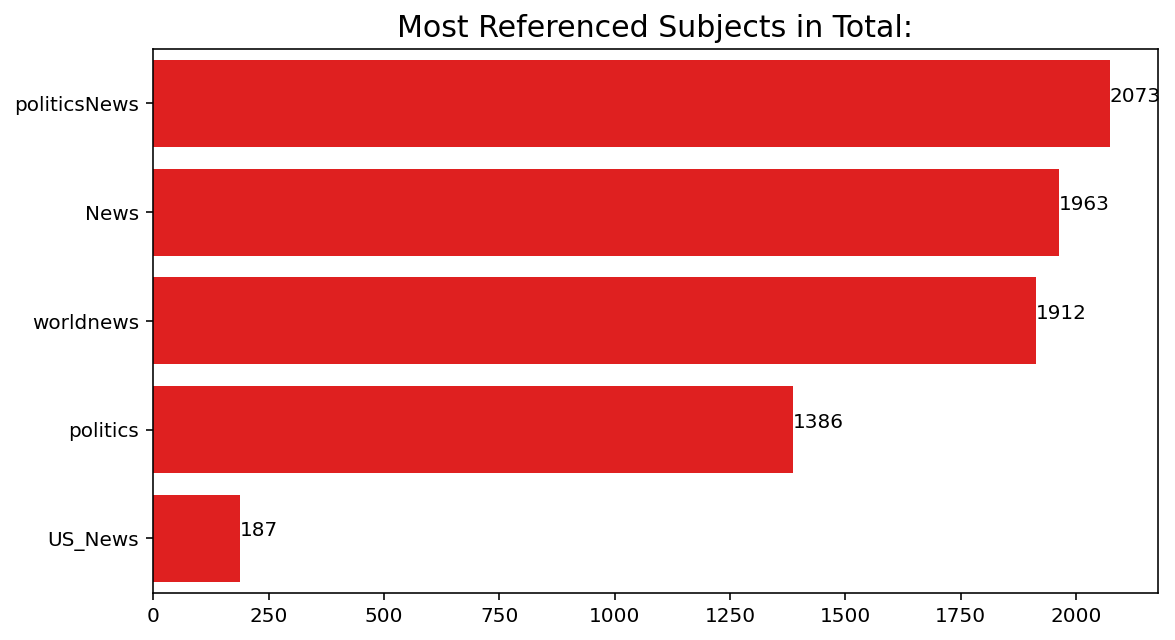

In [0]:
# Set x values: # of posts for both datasets
df_domain = df1['articlesubject'].value_counts() 
df_domain = df_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_domain_index = list(df_domain.index)

# Call function
bar_plot(df_domain.values, df_domain_index, 'Most Referenced Subjects in Total:' ,'r')

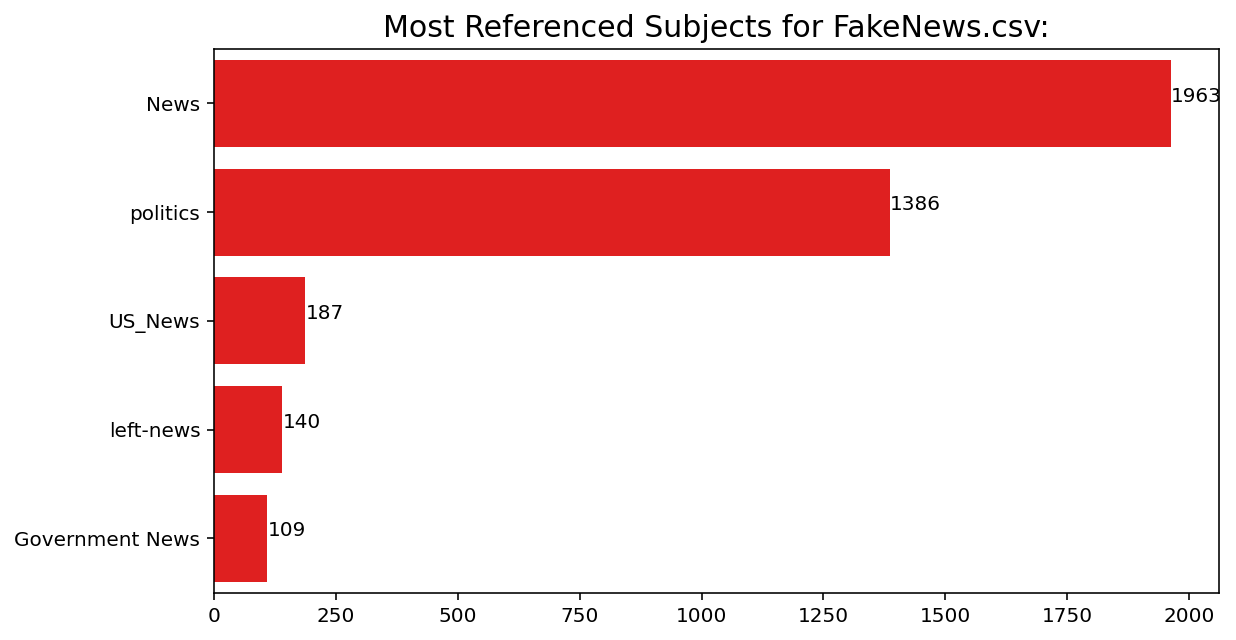

In [0]:
# Set x values: # of posts fake df
df_domain = fake_df['articlesubject'].value_counts() 
df_domain = df_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_domain_index = list(df_domain.index)

# Call function
bar_plot(df_domain.values, df_domain_index, 'Most Referenced Subjects for FakeNews.csv:' ,'r')

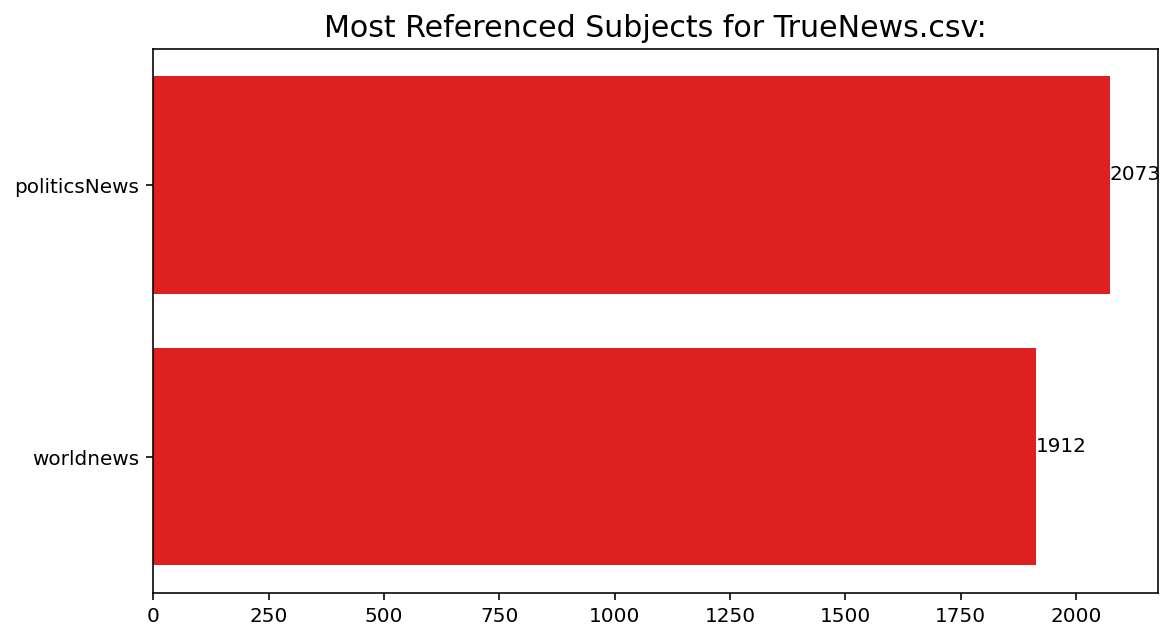

In [0]:
# Set x values: # of posts for true df
df_domain = true_df['articlesubject'].value_counts() 
df_domain = df_domain.sort_values(ascending=False).head(2)

# Set y values: Domains 
df_domain_index = list(df_domain.index)

# Call function
bar_plot(df_domain.values, df_domain_index, 'Most Referenced Subjects for TrueNews.csv:' ,'r')

*Natural Language Processing (NLP)*

**- Apply CountVectorizer()**

*   Count Vectorize df1 where 'label' is 1
*   ngram_range = (1,1)



In [0]:
# Set variables to show Fake Titles
mask_on = df1['label'] == 1
df_onion_titles = df1[mask_on]['articletext']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
onion_cvec = cv1.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of fake Titles cvec
print(onion_cvec_df.shape)

(4001, 39027)



-**Apply CountVectorizer()**
   *   Vectorize df where 'label' is 0
   *   ngram_range = (1,1)



In [0]:
mask_no = df1['label'] == 0
df_not_onion_titles = df1[mask_no]['articletext']

# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv2.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(4001, 31740)


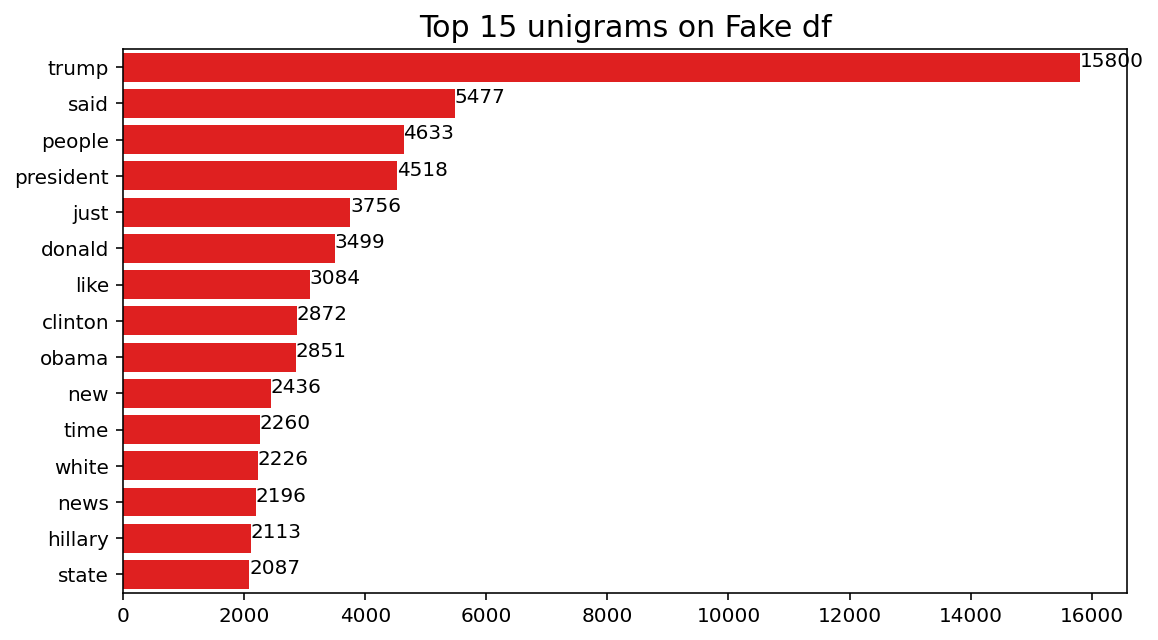

In [0]:
# Set up variables to contain top 15 most used words in Fake df
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(15)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 15 unigrams on Fake df','r')

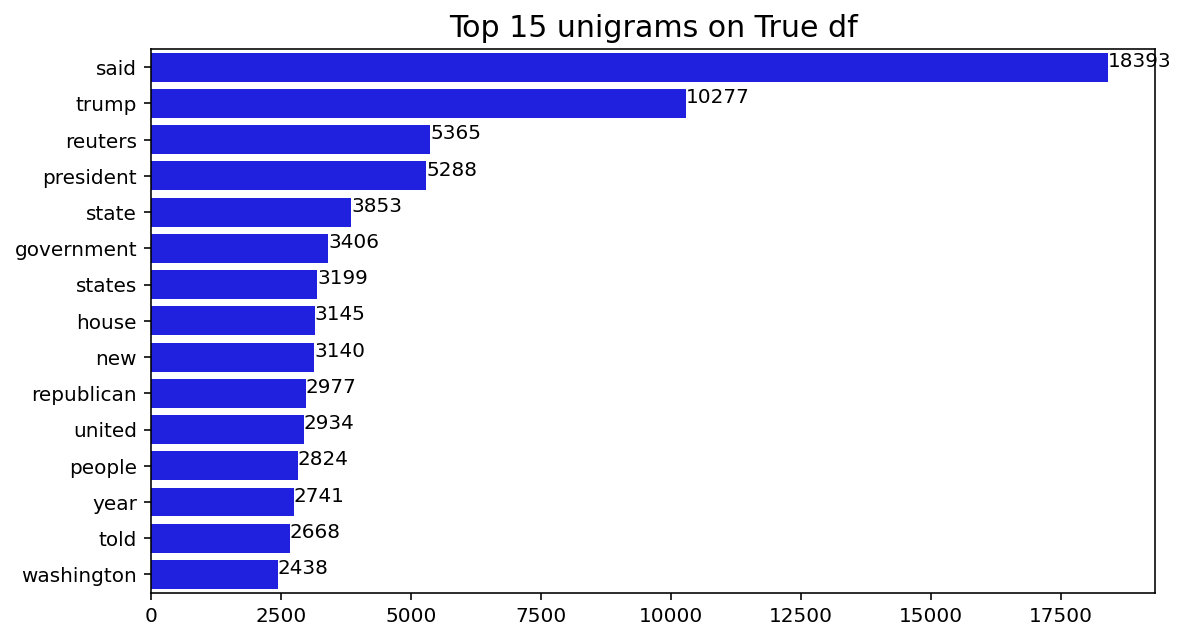

In [0]:
# Set up variables to contain top 15 most used words in Onion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(15)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 15 unigrams on True df','b')

In [0]:
# Create list of unique words in top five
not_onion_5_set = set(nonion_top_5.index)
onion_5_set = set(onion_top_5.index)

# Return common words
common_unigrams = onion_5_set.intersection(not_onion_5_set)
common_unigrams

{'new', 'people', 'president', 'said', 'state', 'trump'}

**-Apply CountVectorize** 
*   Count Vectorize df where "label" is 1
*   ngram_range = (2,2)




In [0]:
# Set variables to show Fake Titles
mask = df1['label'] == 1
df_onion_titles = df1[mask]['articletext']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
onion_cvec = cv.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Fake Titles cvec
print(onion_cvec_df.shape)

***- Apply CountVectorize ***
  *   Count Vectorize df where subreddit is 0
  *   ngram_range = (2,2) 

```
# This is formatted as code
```





In [0]:
# Set variables to show True Titles
mask = df1['label'] == 0
df_not_onion_titles = df1[mask]['articletext']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of  True Titles cvec
print(not_onion_cvec_df.shape)

In [0]:
# Set up variables to contain top  most used bigrams in Fake df
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(35)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top bigrams on Fake df','r')

In [0]:
# Set up variables to contain top  most used bigrams in r/nottheonion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(35)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top bigrams on True df','b')

In [0]:
not_onion_5_list = set(nonion_top_5.index)
onion_5_list = set(onion_top_5.index)

# Return common words
common_bigrams = onion_5_list.intersection(not_onion_5_list)
common_bigrams

Take out {'barack obama','donald trump','hillary clinton','new york','secretary state','supreme court','trump administration','trump said','united states','white house','year old'} from dataset when modeling, since these words occur frequently in both subreddits.

Create custom stop_words to include common frequent words
Referencing the common most-used words, add them to a customized stop_words list.

# **Modeling**

In [0]:
from sklearn.feature_extraction import stop_words
# Create lists 
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

####Here I conduct model-prep and use Pipeline and 

1.   List item
2.   List item

GridSearch to determine the most optimal model to run my data on.


In [0]:
#Baseline Score
df1['label'].value_counts(normalize=True)

####'I expect my model to be better than 54%. The majority class is 0, or, True. If the model is not better than 54%, I know the model is not performing well.'


In [0]:
#Set X (predictor) and y (target) variables
X = df1['articletext']
y = df1['label']

In [0]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

**Model 1**: *CountVectorizer & Logistic Regression*

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix


pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

####while the model is overfit, I am optimizing to get the highest accuracy score in my test set



```
# This is formatted as code
```

**Model 2: TfidfVectorize & Logistic Regression** 





In [0]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

**Model 3: CountVectorizer & MultinomialNB**

In [0]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

**Model 4: TfidfVectorizer & MultinomialN**B

In [0]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

**##CountVectorizer & MultinomialNB**

In [0]:
#Instantiate the classifier and vectorizer
nb = MultinomialNB(alpha = 0.36)
cvec = CountVectorizer(ngram_range= (1, 3))

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit the classifier
nb.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
preds = nb.predict(Xcvec_test)

print(nb.score(Xcvec_test, y_test))

#Confusion Matrix

In [0]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

In [0]:
# Code from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [0]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [0]:

print("Accuracy:",round(metrics.accuracy_score(y_test, preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')